In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
import time
from pathlib import Path
import pytesseract
from PIL import Image
from tqdm.autonotebook import tqdm
from functools import reduce
import operator 

def imshow(x):
    fig = plt.figure()
    plt.imshow(x)
    return fig

frames_dir = Path('/home/francesco/Documents/Kanga-Challenge/source/dataset/videos/evo2014/frames/')

/home/francesco/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


## Exploring Traces
Text will usually be present in at least 3/4 frames since it has to be read by humans. We can try to see if we are able to mask it correctly

In [6]:
from data import VideoDataset
from torch.utils.data import DataLoader, random_split

In [7]:
def imread_convert(x):
    x = cv2.imread(str(x))
    if x is not None:
        x = cv2.resize(x, (320, 320))
        x = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
    return x

paths = list(frames_dir.glob('*.jpg'))
paths.sort(key=lambda a: int(a.name.split('.')[0]))
frames = list(tqdm(map(imread_convert, paths)))


<IPython.core.display.Javascript object>


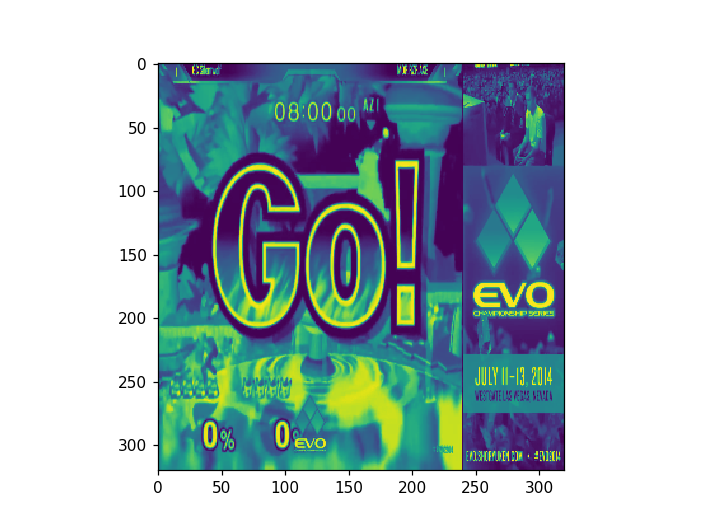

<IPython.core.display.Javascript object>


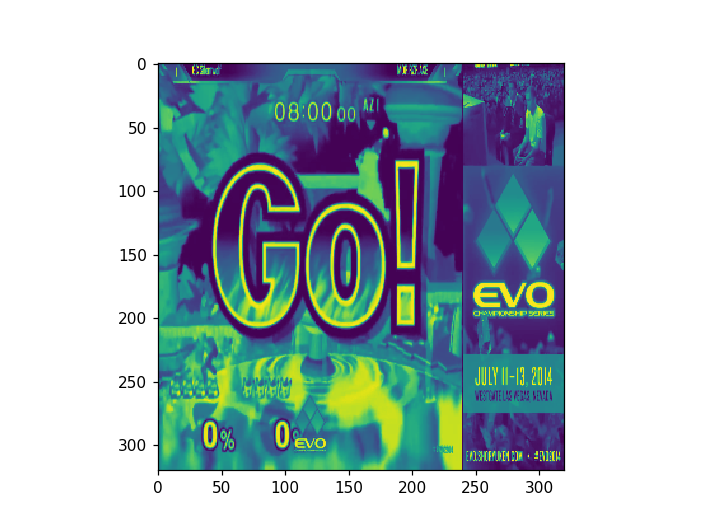

In [49]:
imshow(frames[195])

In [94]:
x = frames[600].astype(np.float) - frames[661].astype(np.float)
mask = np.zeros_like(x)
indices = x[-0.1 < x &  x > 0.1]
mask[indices] = 255
# x[x > 0] = 255
# x[x < 0] = 0
plt.imshow(mask, cmap = 'gray')

SyntaxError: invalid syntax (<ipython-input-94-e00f6f37edbf>, line 3)

## Find text in image
We can use something like this
[EAST: An Efficient and Accurate Scene Text Detector
](https://arxiv.org/abs/1704.03155)
### OpenCV
https://www.pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/

In [52]:
from detection import TextDetector

<IPython.core.display.Javascript object>


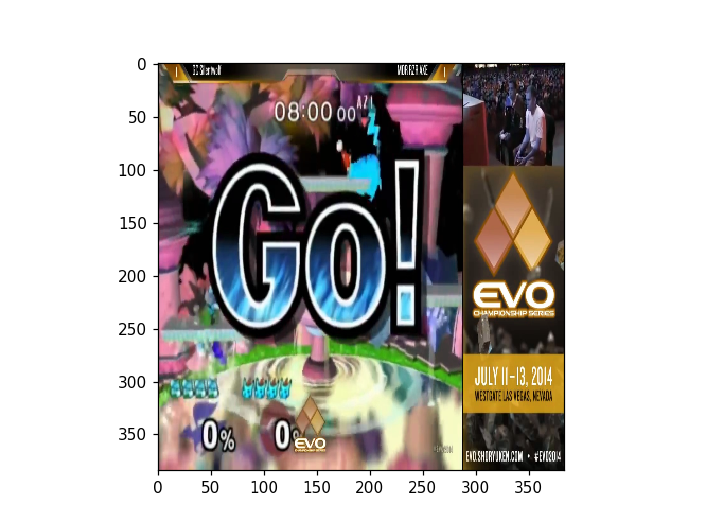

(384, 384, 3)


2019-12-05 22:45:31,059 - [INFO] - Text detection took 0.202084 seconds


In [198]:
file_path =  '/home/francesco/Documents/Kanga-Challenge/source/dataset/videos/evo2014/frames/196.jpg'

img = cv2.imread(file_path)
det = TextDetector()
det([img])

<IPython.core.display.Javascript object>


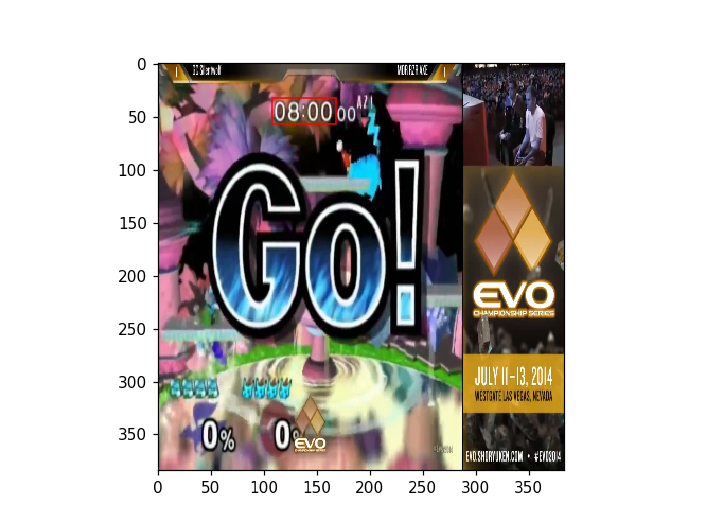

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fefa27aa510>)

In [187]:
det.plot_boxes(img_r)

In [ ]:
from PIL import Image
import pytesseract


print(pytesseract.image_to_string(Image.open(file_path).convert('LA')))

## Yolo


<IPython.core.display.Javascript object>


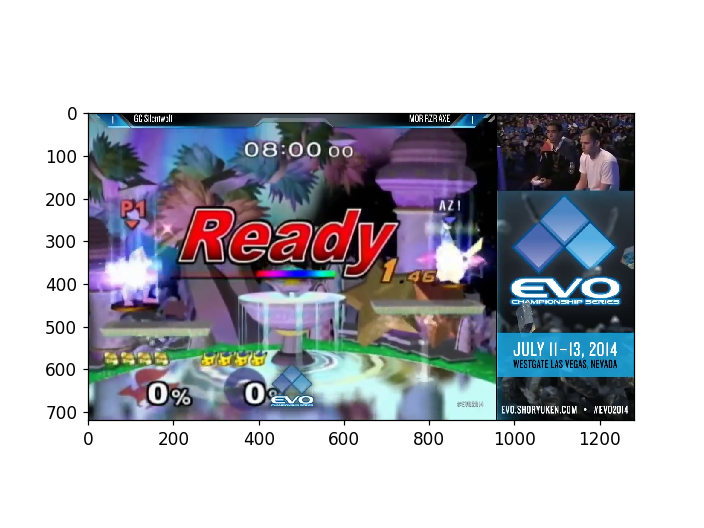


[tensor([[2.45000e+02, 5.53000e+02, 4.09000e+02, 5.92000e+02, 9.80988e-01, 9.99990e-01, 2.00000e+00],
        [3.70000e+01, 5.49000e+02, 1.93000e+02, 5.95000e+02, 9.71229e-01, 9.99951e-01, 2.00000e+00],
        [1.31000e+02, 6.21000e+02, 1.89000e+02, 6.90000e+02, 9.14900e-01, 9.99973e-01, 3.00000e+00],
        [5.30000e+02, 2.65000e+02, 7.63000e+02, 4.09000e+02, 7.28347e-01, 9.97659e-01, 0.00000e+00],
        [3.81000e+02, 5.40000e+01, 6.34000e+02, 1.16000e+02, 7.26415e-01, 9.99978e-01, 1.00000e+00],
        [6.80000e+01, 1.91000e+02, 1.60000e+02, 2.63000e+02, 6.71860e-01, 8.87411e-01, 3.00000e+00],
        [3.49000e+02, 6.14000e+02, 4.10000e+02, 6.83000e+02, 6.70777e-01, 9.99912e-01, 3.00000e+00]])]


In [4]:
from Project import Project
import torch
from pathlib import Path
from data.transformation import Yolov3Transform
from detection import Yolov3Detector, OCRDetector
from detection.Yolov3Detector import Yolov3Prediction
import cv2
import numpy as np
from torchvision.transforms import Compose, Lambda, ToTensor
import matplotlib.pyplot as plt
from dataclasses import dataclass
import pprint

classes = {0: 'player', 1: 'time', 2: 'stocks', 3: 'damage'}
transform = Compose([
    Yolov3Transform(),
    ToTensor(),
])

detector = Yolov3Detector(weights='./yolov3/weights/best.pt',
                  cfg='./yolov3/cfg/yolov3-tiny-frames.cfg',
                  view_img=True,
                  classes=classes,
                  transform=transform)

root = Project().data_dir / 'videos' / 'evo2014' / 'frames'

img = cv2.imread('./yolov3/data/samples/160.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
imshow(img)
preds = detector([img], conf_thres=0.5)
# yolov3_pred = Yolov3Prediction(preds[0])
pprint.pprint(preds)

## EAST + tesseract
form the player names

<IPython.core.display.Javascript object>


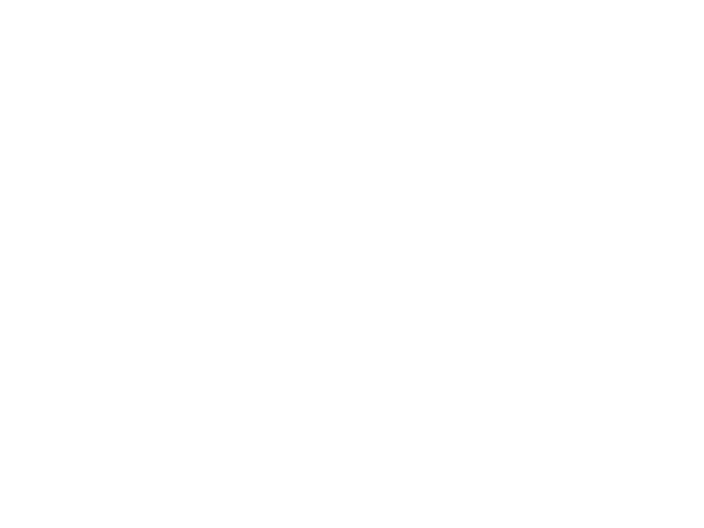

<IPython.core.display.Javascript object>


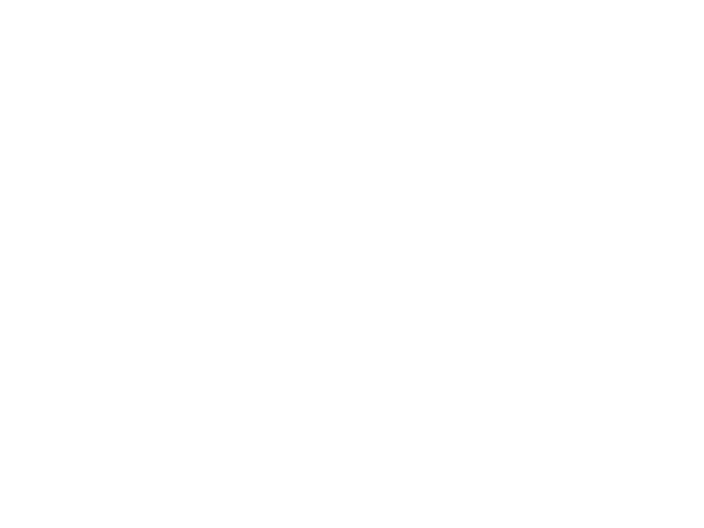

2019-12-15 15:40:53,782 - [INFO] - Text detection took 0.450182 seconds


<IPython.core.display.Javascript object>


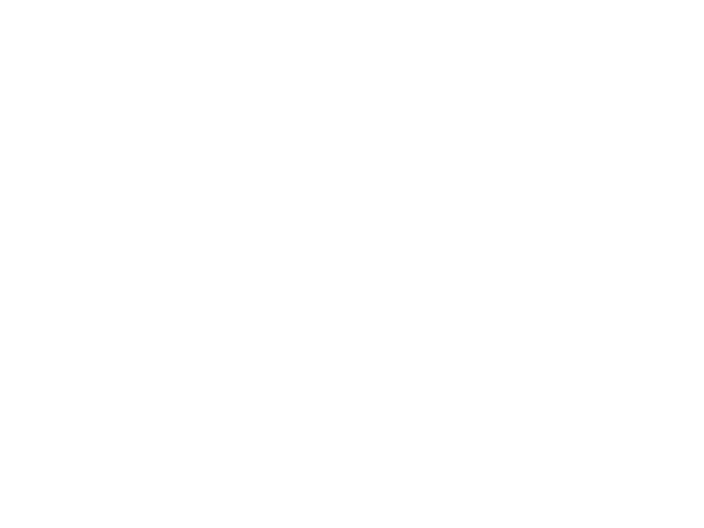

'MDR WAX'

In [294]:
from detection import EASTTextDetector

_ = imshow(img)
east_detector = EASTTextDetector()
img.shape[0]
x = int(time['coord'][1])
y = int(time['coord'][0])
y2 = int(time['coord'][2])
left_time, right_time = img[:x, :y], img[:x, y2:]
# left_time = cv2.cvtColor(left_time, cv2.COLOR_RGB2GRAY)
# left_time = left_time > 
left_time = cv2.resize(left_time, (left_time.shape[1] * 4, left_time.shape[0] * 4))

pad_top_bottom = right_time.shape[1] - left_time.shape[0]

# make a square
right_time = cv2.copyMakeBorder(right_time, pad_top_bottom // 2, pad_top_bottom//2, 0,0, cv2.BORDER_CONSTANT,
    value=[0,0,0])
_ = imshow(right_time)

right_time = cv2.resize(right_time, (320, 320))

east_detector([right_time])
box = east_detector.boxes[0]
x1, y1, x2, y2 = box
crop = right_time[y1:y2, x1:x2]
# east_detector.boxes
# east_detector.plot_boxes(right_time)

# # _ = imshow(right_time)
# crop = cv2.resize(crop, (crop.shape[1] * 4, crop.shape[0] * 4))
crop = cv2.copyMakeBorder(crop, 28, 28, 28,28, cv2.BORDER_CONSTANT, value=[0,0,0])
_ = imshow(crop)

x = Image.fromarray(crop)

text = pytesseract.image_to_string(x, lang='eng', config='--psm 7 --oem 0')
text

## Pandas

In [225]:
import pandas as pd
preds_np = preds[0].numpy()

current = pd.DataFrame(preds2[0].numpy(), columns=['x', 'y', 'x2', 'y2', 'conf', 'foo', 'cls'])
prev = pd.DataFrame(preds1[0].numpy(), columns=['x', 'y', 'x2', 'y2', 'conf', 'foo', 'cls'])

history = [prev, current]

In [179]:
def crops_from_df_preds(preds, src):
        for i, det in preds.iterrows():
            crop = src[int(det.y):int(det.y2), int(det.x):int(det.x2)]
            yield crop

In [210]:
prev.crop[0].shape

(182, 257, 3)

In [228]:
img = cv2.imread('./yolov3/data/samples/160.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
imshow(img)
preds = detector([img], conf_thres=0.5)
# yolov3_pred = Yolov3Prediction(preds[0])
pprint.pprint(preds)

In [229]:
from detection import Detector
from scipy.spatial.distance import cdist

class StooqDetector(Detector):
    cls: int = 2
    area_tr = .3
    
    def detect(self, img):
        preds, prev = history[-1], history[-2]
        preds = preds[preds['cls'] == 2].reset_index(drop=True)
        prev = prev[prev['cls'] == 2].reset_index(drop=True)
        current = self.add_area(current)
        prev = self.add_area(prev)
        #  Get distance matrix
        Y = cdist(current[['x', 'y', 'x2', 'y2']], prev[['x', 'y', 'x2', 'y2']])
        for i, det in preds.iterrows():
            closed_det_prev = prev.iloc[np.argmin(Y[i])]
            imshow(det.crop)
            imshow(closed_det_prev.crop)
            if abs(np.abs(det.area - closed_det_prev.area)/ det.area) > self.area_tr:
                print('stock changed')
                
    def add_area(self, df):
        def _inner(x):
            return x.crop.shape[0] * x.crop.shape[1]
        
        df['area'] = df.apply(_inner, axis=1)
        return df
    
    

<IPython.core.display.Javascript object>


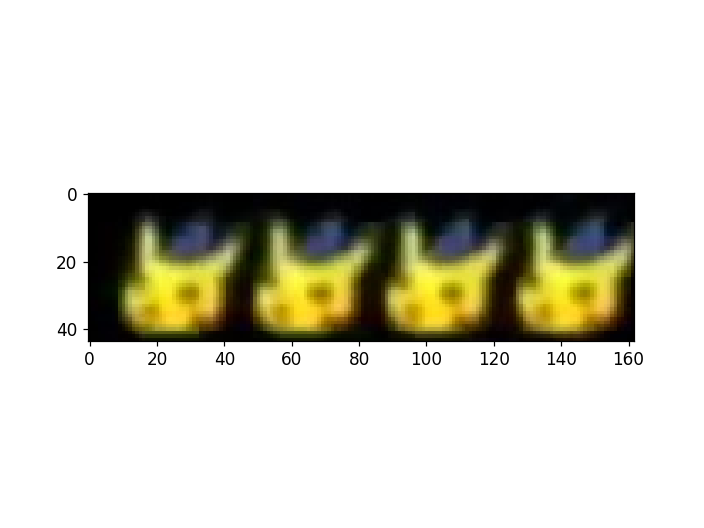

<IPython.core.display.Javascript object>


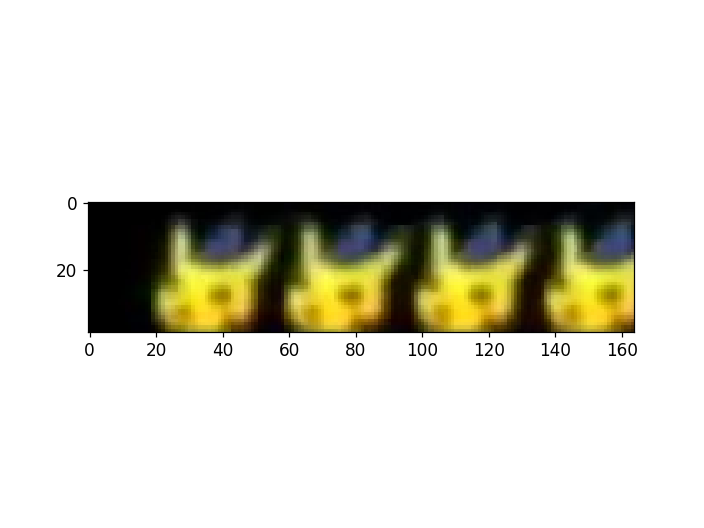

<IPython.core.display.Javascript object>


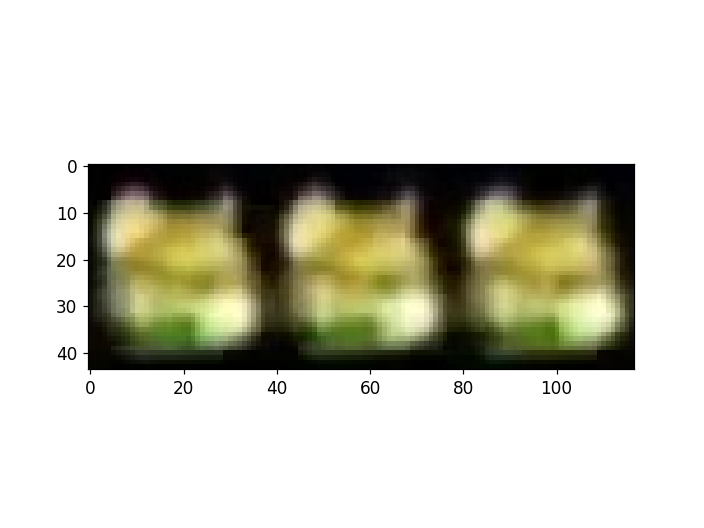

<IPython.core.display.Javascript object>


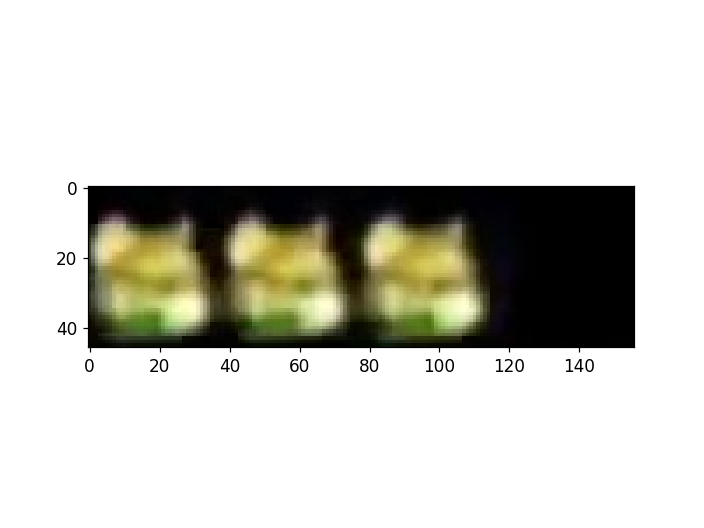

stock changed


In [230]:
history = [prev, current]
StooqDetector()(history)

In [84]:
current[current['cls'] == 2]

,x,y,x2,y2,conf,foo,cls
0,245.0,553.0,409.0,592.0,0.980988,0.999990,2.0
1,37.0,549.0,193.0,595.0,0.971229,0.999951,2.0


In [70]:
from scipy.spatial.distance import cdist

Y = cdist(current[['x', 'y', 'x2', 'y2']], prev[['x', 'y', 'x2', 'y2']])

In [71]:
np.argmin(Y[0])

1